<center><h1>Section 5-2A Output Graphics</h1></center>

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display, HTML

root_directory = os.path.dirname(os.path.dirname(os.getcwd()))
if os.path.join(root_directory, 'src') not in sys.path:
    sys.path.append(os.path.join(root_directory, 'src'))

from graphics_renderer import GraphicsRenderer

%matplotlib widget
%matplotlib inline

In [2]:
gr = GraphicsRenderer('RESULTS5-2A-Test-0.0.0.json')
HTML(gr._set_html_style())

In [3]:
table_html, msg = gr.render_section_5_2a_table_b_8_1()
table_html

cases,BSIMAC 9-9.0.74,CSE-0.861.1,DeST-2.0-20190401,ESP-r-13.3,EnergyPlus-Version 9.0.1,TRNSYS-TRNSYS 18.00.0001
"600 Base Case, South Windows",4.050,3.992755,4.047,4.3620,4.324,4.503550
610 S. Windows + Overhang,4.163,4.066423,4.144,4.5270,4.375,4.592060
620 East & West Windows,4.370,4.093598,4.297,4.5143,4.485,4.718980
630 E&W Windows + Overhang & Fins,4.923,4.355946,4.677,5.0506,4.784,5.138580
640 Case 600 with Htg Temp. Setback,2.682,2.403242,2.619,2.6544,2.662,2.652750
650 Case 600 with Night Ventilation,0.000,0.000000,0.000,0.0000,0.000,0.000000
660 Low-E Windows,3.574,3.601959,3.821,3.7870,3.707,3.789660
670 Single-Pane Windows,5.484,5.300178,5.573,5.9750,5.616,6.139870
680 Case 600 with Increased Insulation,2.219,1.786102,1.732,2.1321,2.180,2.286260
"685 Case 600 with ""20/20"" Thermostat",4.532,4.574428,4.646,4.9035,4.877,5.042170


In [4]:
table_html, msg = gr.render_section_5_2a_table_b_8_2()
table_html

cases,BSIMAC 9-9.0.74,CSE-0.861.1,DeST-2.0-20190401,ESP-r-13.3,EnergyPlus-Version 9.0.1,TRNSYS-TRNSYS 18.00.0001
"600 Base Case, South Windows",5.822,5.913124,5.432,6.1618,6.027,5.779520
610 S. Windows + Overhang,4.299,4.381794,4.173,4.2325,4.333,4.116800
620 East & West Windows,4.404,4.079308,3.909,4.2457,4.060,3.840650
630 E&W Windows + Overhang & Fins,3.074,3.020403,2.787,2.5953,2.836,2.572870
640 Case 600 with Htg Temp. Setback,5.804,5.643913,5.237,5.8926,5.763,5.477220
650 Case 600 with Night Ventilation,4.629,4.653881,4.186,4.9451,4.817,4.632340
660 Low-E Windows,3.014,3.339690,3.260,3.2186,3.232,2.966250
670 Single-Pane Windows,6.539,6.577744,5.954,6.5203,6.623,6.197800
680 Case 600 with Increased Insulation,5.938,6.429816,5.932,6.5294,6.444,6.309750
"685 Case 600 with ""20/20"" Thermostat",9.130,8.859209,8.238,9.1214,9.119,8.851290


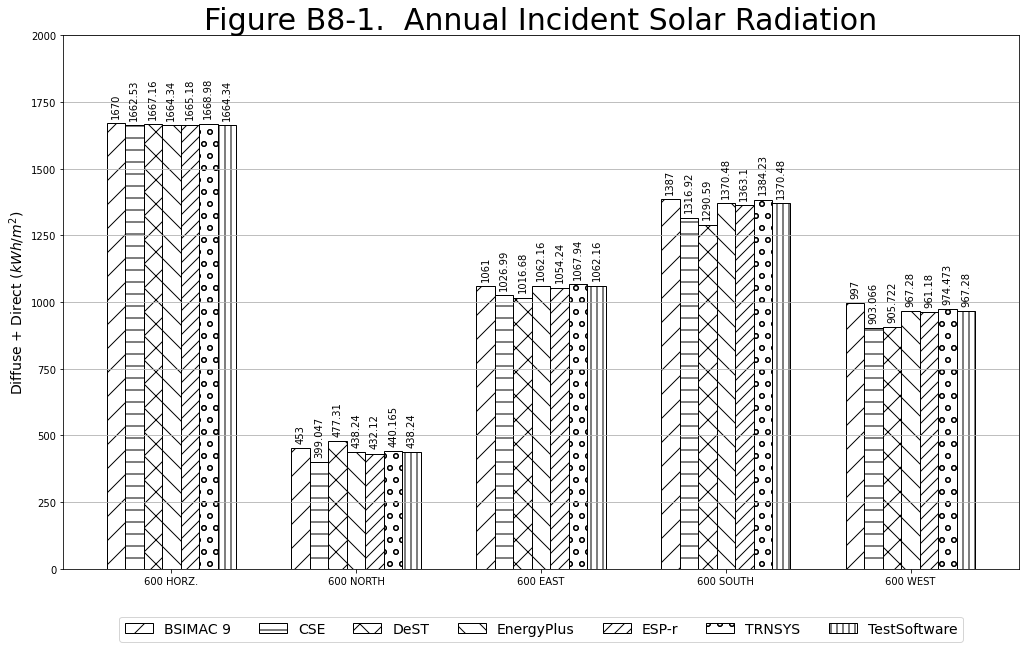

In [5]:
gr.render_section_5_2a_figure_b_8_1()
plt.show();

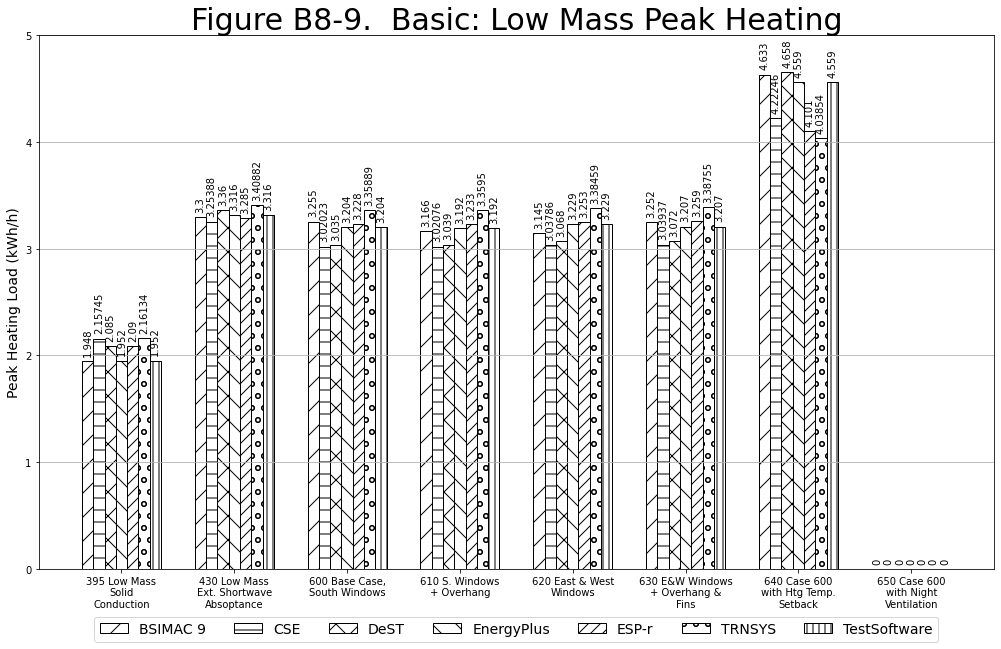

In [6]:
gr.render_section_5_2a_figure_b_8_9()
plt.show();

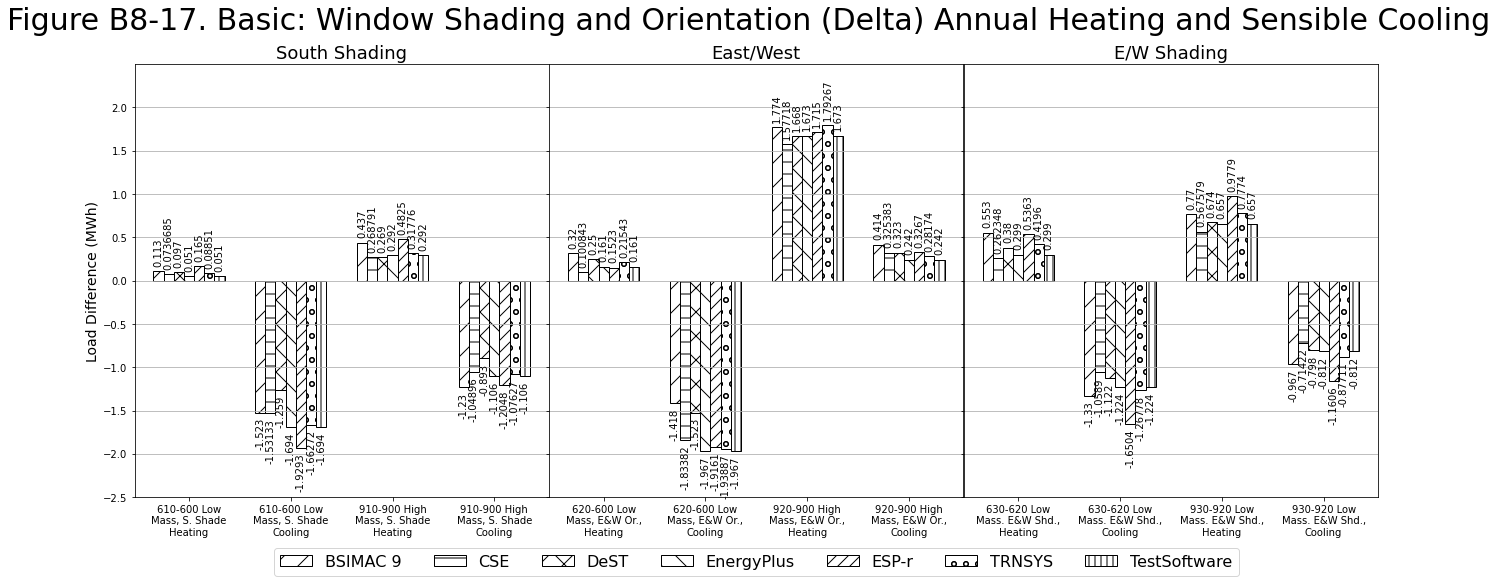

In [7]:
gr.render_section_5_2a_figure_b8_17()
plt.show();

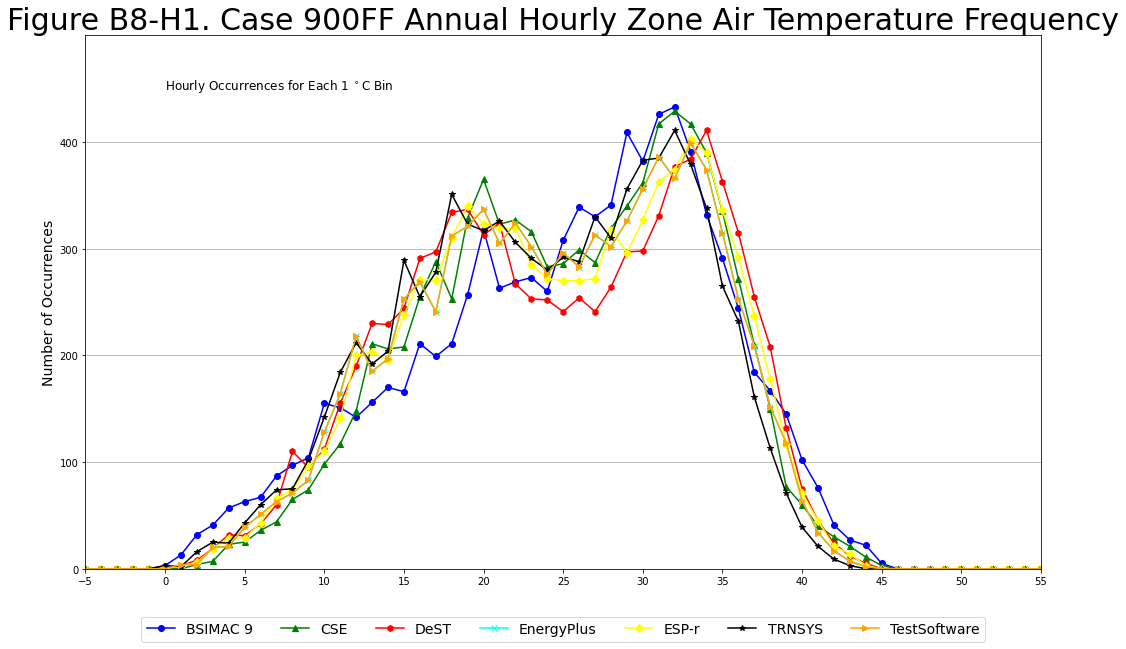

In [8]:
gr.render_section_5_2a_figure_b8_h1()
plt.show();

In [9]:
# Example Dataframe storage object
gr.df_data

{'conditioned_zone_loads_non_free_float':                                              195                     \
                               annual_cooling_MWh annual_heating_MWh   
 program_name                                                          
 RESULTS5-2A-BSIMAC-9-9.0.74             0.712000           4.217000   
 RESULTS5-2A-CSE-0.861.1                 0.605525           3.990079   
 RESULTS5-2A-DeST-2.0-20190401           0.628000           4.157000   
 RESULTS5-2A-EnergyPlus-9.0.1            0.612000           4.070000   
 RESULTS5-2A-ESP-r-13.3                  0.611000           3.950900   
 RESULTS5-2A-TRNSYS-18.00.0001           0.591534           4.093940   
 RESULTS5-2A-Test-0.0.0                  0.612000           4.070000   
 
                                                                   \
                               peak_cooling_day peak_cooling_hour   
 program_name                                                       
 RESULTS5-2A-BSIMAC-9-9.0.74  

In [10]:
# Example dataframe display
display(gr.df_data['conditioned_zone_loads_non_free_float'])

195                     \
                              annual_cooling_MWh annual_heating_MWh   
program_name                                                          
RESULTS5-2A-BSIMAC-9-9.0.74             0.712000           4.217000   
RESULTS5-2A-CSE-0.861.1                 0.605525           3.990079   
RESULTS5-2A-DeST-2.0-20190401           0.628000           4.157000   
RESULTS5-2A-EnergyPlus-9.0.1            0.612000           4.070000   
RESULTS5-2A-ESP-r-13.3                  0.611000           3.950900   
RESULTS5-2A-TRNSYS-18.00.0001           0.591534           4.093940   
RESULTS5-2A-Test-0.0.0                  0.612000           4.070000   

                                                                  \
                              peak_cooling_day peak_cooling_hour   
program_name                                                       
RESULTS5-2A-BSIMAC-9-9.0.74               26.0              17.0   
RESULTS5-2A-CSE-0.861.1                   26.0              17.0   
RESULTS5-2A-DeST-2.0-20190401             26.0              16.0   
RESULTS5-2A-EnergyPlus-9.0.1              26.0              17.0   
RESULTS5-2A-ESP-r-13.3                    26.0              17.0   
RESULTS5-2A-TRNSYS-18.00.0001             26.0              17.0   
RESULTS5-2A-Test-0.0.0                    26.0              17.0   

                                                                  \
                              peak_cooling_kW peak_cooling_month   
program_name                                                       
RESULTS5-2A-BSIMAC-9-9.0.74          1.118000                Jun   
RESULTS5-2A-CSE-0.861.1              0.994253                Jun   
RESULTS5-2A-DeST-2.0-20190401        0.973000                Jun   
RESULTS5-2A-EnergyPlus-9.0.1         1.041000                Jun   
RESULTS5-2A-ESP-r-13.3               0.944000                Jun   
RESULTS5-2A-TRNSYS-18.00.0001        0.993513                Jun   
RESULTS5-2A-Test-0.0.0               1.041000                Jun   

                                                                  \
                              peak_heating_day peak_heating_hour   
program_name                                                       
RESULTS5-2A-BSIMAC-9-9.0.74               31.0              24.0   
RESULTS5-2A-CSE-0.861.1                    1.0               1.0   
RESULTS5-2A-DeST-2.0-20190401              1.0               0.0   
RESULTS5-2A-EnergyPlus-9.0.1              31.0              24.0   
RESULTS5-2A-ESP-r-13.3                     1.0               1.0   
RESULTS5-2A-TRNSYS-18.00.0001              1.0               1.0   
RESULTS5-2A-Test-0.0.0                    31.0              24.0   

                                                                  ...  \
                              peak_heating_kW peak_heating_month  ...   
program_name                                                      ...   
RESULTS5-2A-BSIMAC-9-9.0.74          1.802000                Dec  ...   
RESULTS5-2A-CSE-0.861.1              1.790699                Jan  ...   
RESULTS5-2A-DeST-2.0-20190401        1.799000                Jan  ...   
RESULTS5-2A-EnergyPlus-9.0.1         1.794000                Dec  ...   
RESULTS5-2A-ESP-r-13.3               1.802000                Jan  ...   
RESULTS5-2A-TRNSYS-18.00.0001        1.795922                Jan  ...   
RESULTS5-2A-Test-0.0.0               1.794000                Dec  ...   

                                             995                     \
                              annual_cooling_MWh annual_heating_MWh   
program_name                                                          
RESULTS5-2A-BSIMAC-9-9.0.74             7.482000           1.330000   
RESULTS5-2A-CSE-0.861.1                 7.202152           0.755182   
RESULTS5-2A-DeST-2.0-20190401           6.771000           0.770000   
RESULTS5-2A-EnergyPlus-9.0.1            7.203000           1.006000   
RESULTS5-2A-ESP-r-13.3                  7.148800           0.90

In [11]:
# Example json storage object
from pprint import pprint
pprint(gr.json_data['RESULTS5-2A-BSIMAC-9-9.0.74']['annual_solar_radiation_direct_and_diffuse'])

{'600': {'Surface': {'EAST': {'kWh/m2': 1061},
                     'HORZ.': {'kWh/m2': 1670},
                     'NORTH': {'kWh/m2': 453},
                     'SOUTH': {'kWh/m2': 1387},
                     'WEST': {'kWh/m2': 997}}}}
